<center>
    <img src="https://drive.google.com/uc?export=view&id=1hDKusF04c0lNZA_qOShvWQrpImayVKz8"  width="1000" />
</center>

# Tugas Mandiri
---
Tugas mandiri ini digunakan pada kegiatan Kursus Data Science yang merupakan pembekalan bagi mahasiswa Universitas Gunadarma untuk Skema Associate Data Scientist

### Pertemuan 4 - Semester 8

1. Buatlah model klasifikasi dengan machine learning dari dataset yang diberikan dengan ketentuan :
    - Gunakan metode CRISP-DM secara terurut dan lengkap
    - Gunakan algoritma linear regression, logistic regression, dan K-NN

2. Dari ketiga algoritma yang anda pakai, algoritma yang manakah yang memiliki akurasi paling tinggi?

## Dataset Information

1. Kolom Flight -> ID Flight
2. Kolom Time -> Waktu keberangkatan dalam format menit dalam 24 jam
Contoh : 870 -> 14.30
3. Kolom Length -> Durasi penerbangan dalam format menit
4. Kolom Airline -> Kode dari setiap maskapai
5. Kolom AirportFrom -> Kode dari bandara keberangkatan
6. Kolom AirportTo -> Kode dari bandara tujuan
7. Kolom DayOfWeek -> Hari dalam seminggu (1 = Senin, 2 = Selasa, dst)
8. Kolom Class -> Kategori penerbangan tersebut delay (1) atau tidak delay (0)

## Data Preparation

### Exploratory Data Analysis (EDA)

In [199]:
import pandas as pd

df = pd.read_csv("dataset_tm_10k.csv")

In [200]:
df.head(5)

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,320.0,870.0,180.0,NaN,IAH,PHX,5,0
1,3045.0,365.0,66.0,OO,DSM,MKE,2,0
2,1560.0,740.0,257.0,DL,SEA,CVG,7,0
3,1156.0,595.0,235.0,WN,SNA,MDW,7,1
4,1873.0,530.0,133.0,CO,IAH,MCO,6,1


In [201]:
df.Flight = df.Flight.astype(str)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Flight       10787 non-null  object 
 1   Time         9914 non-null   float64
 2   Length       9444 non-null   float64
 3   Airline      10205 non-null  object 
 4   AirportFrom  10787 non-null  object 
 5   AirportTo    10787 non-null  object 
 6   DayOfWeek    10787 non-null  int64  
 7   Class        10787 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 674.3+ KB


In [203]:
import seaborn as sns
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 

def describe_info_dataset(df :pd.DataFrame):
    # Check type variabel each column
    # print(df.info())
    # Check Missing Value
    print("Missing Value Information\n", df.isnull().sum())
    # print info basic dataset
    print(df.describe())

def check_correlation_variables(df: pd.DataFrame):
    sns.heatmap(df.select_dtypes(exclude=['object']).corr(), annot=True)

def diagnostic(df, var):
    fig = plt.figure(figsize = (17, 6))
    plt.subplot(1,3,1)
    df[var].hist(bins = 40)
    plt.title("Distribution of {}".format(var))
    
    # for check normal distribution
    # plt.subplot(1,3,2)
    # stats.probplot(df[var], dist = "norm", plot = plt)
    # plt.ylabel("Quantiles")

    plt.subplot(1,3,3)
    sns.boxplot(y = df[var])
    plt.title("Boxplot")
    plt.show()

def run_diagnostic(df):
    numeric_vars = df.select_dtypes("number")
    for var in numeric_vars:
        diagnostic(df, var)

In [204]:
describe_info_dataset(df)

Missing Value Information
 Flight            0
Time            873
Length         1343
Airline         582
AirportFrom       0
AirportTo         0
DayOfWeek         0
Class             0
dtype: int64
              Time       Length     DayOfWeek         Class
count  9914.000000  9444.000000  10787.000000  10787.000000
mean    803.378253   133.429161      3.895430      0.447576
std     276.880784    71.861876      1.923294      0.497267
min      15.000000    29.000000      1.000000      0.000000
25%     570.000000    81.000000      2.000000      0.000000
50%     795.000000   116.000000      4.000000      0.000000
75%    1034.000000   164.000000      5.000000      1.000000
max    1439.000000   655.000000      7.000000      1.000000


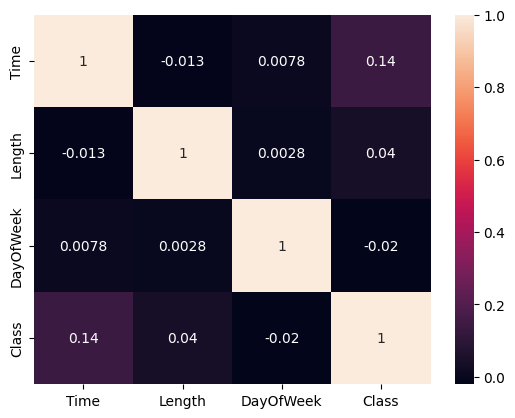

In [205]:
check_correlation_variables(df)

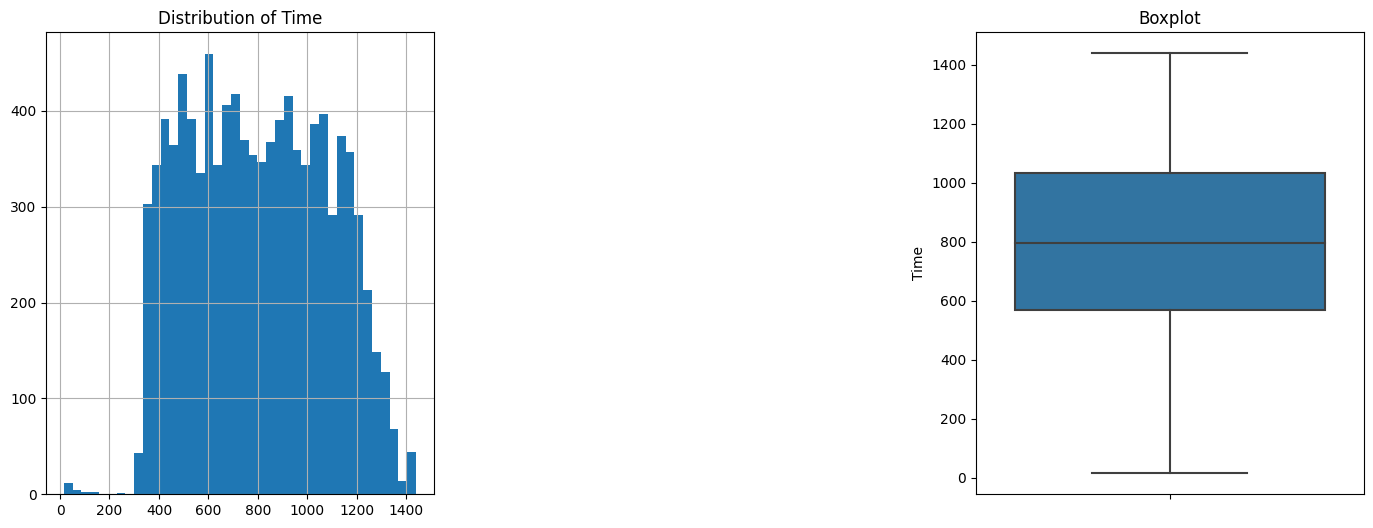

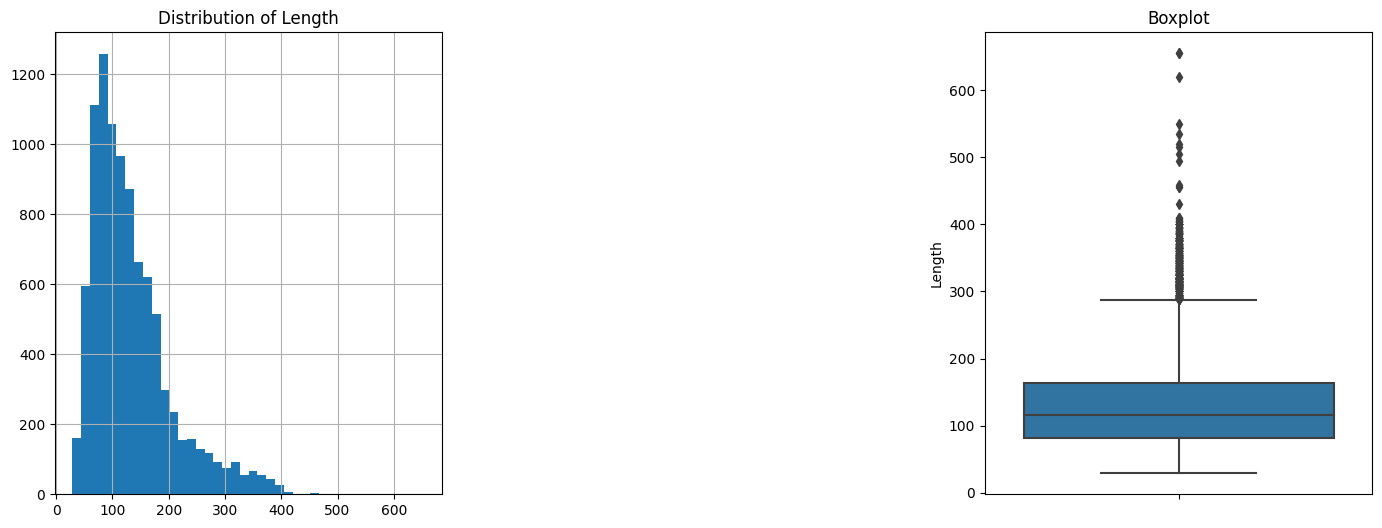

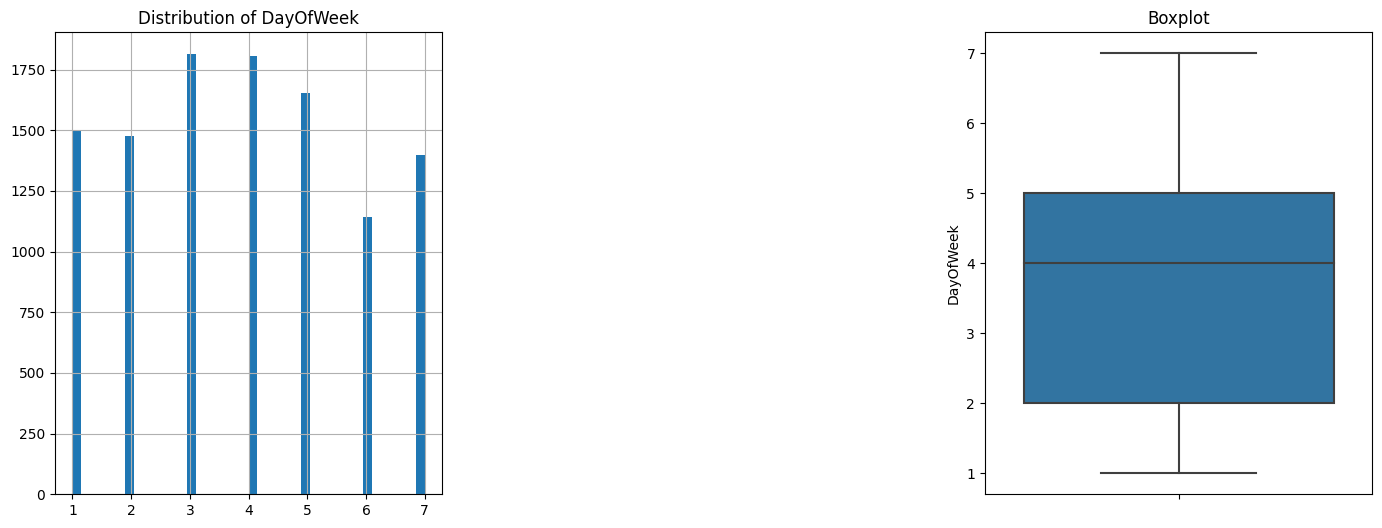

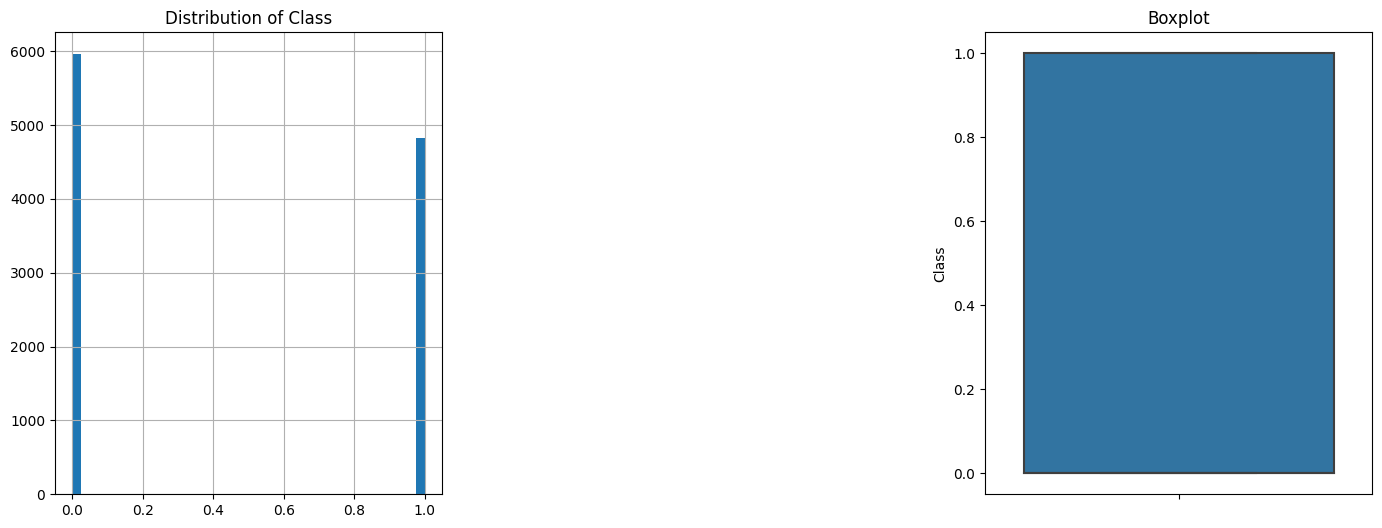

In [206]:
run_diagnostic(df)

Hasil dari load data terdapat dua hal yang perlu dilakukan yaitu:
1. Terdapat 3 buah categorical variabel yaitu ID Flight, Airline, AirportFrom, dan AirportTo sebagai independent variabel untuk status apakah maskapai tersebut delay atau tidak.
2. Terdapat perbedaan range (nilai min dan nilai max) untuk day of week (nomor hari) dengan time, length yang sangat jauh perlu dilakukan normalisasi.
3. Terdapat outlier pada variabel feature Length yang perlu dihandle agar tidak mempengaruhi output dari prediksi model.
4. Terdapat missing value pada feature variabel Time, Length, dan Airline

## Dataset Preparation

Tahapan Preprocessing meliputi :
1. Handle outlier pada variabel Length dan missing value (untuk numeric dan categorical attribute)
2. Handle categorical attribute.
3. Normalisasi feature numeric.

In [207]:
from scipy.stats.mstats import winsorize
from sklearn.impute import KNNImputer, SimpleImputer

def handle_outlier_winsorizing(df: pd.DataFrame,
                               limits: list,
                               outlier_columns: list) -> pd.DataFrame:
    for outlier_colum in outlier_columns:
        df[outlier_colum] = winsorize(df[outlier_colum], limits=limits)
    return df

def handle_missing_value_numeric(df: pd.DataFrame):
    imputer = KNNImputer(n_neighbors=2)
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

def handle_categorical_missing_value(df: pd.DataFrame):
    imputer = SimpleImputer(strategy="most_frequent")
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

def handle_missing_value(df: pd.DataFrame):
    num_df = df.select_dtypes(exclude="object")
    cat_df = df.select_dtypes(include="object")
    num_df = handle_missing_value_numeric(num_df)
    cat_df = handle_categorical_missing_value(cat_df)
    
    # left_col = num_df.columns[0]
    # right_col = cat_df.columns[0]
    # # print(num_df)
    # # print(type(cat_df))
    # print(left_col)
    # print(right_col)
    return pd.concat([num_df, cat_df], axis=1)

In [208]:
df = handle_missing_value(df)

In [209]:
df

,Time,Length,DayOfWeek,Class,Flight,Airline,AirportFrom,AirportTo
0,870.0,180.0,5.0,0.0,320.0,WN,IAH,PHX
1,365.0,66.0,2.0,0.0,3045.0,OO,DSM,MKE
2,740.0,257.0,7.0,0.0,1560.0,DL,SEA,CVG
3,595.0,235.0,7.0,1.0,1156.0,WN,SNA,MDW
4,530.0,133.0,6.0,1.0,1873.0,CO,IAH,MCO
...,...,...,...,...,...,...,...,...
10782,610.0,50.0,2.0,0.0,2821.0,MQ,DFW,SPS
10783,839.0,118.0,2.0,0.0,2618.0,XE,SDF,EWR
10784,1160.0,124.0,2.0,0.0,1973.0,DL,ATL,MIA
10785,1275.0,112.0,4.0,0.0,528.0,US,PHX,RNO


In [210]:
df = handle_outlier_winsorizing(df=df, limits=[0, 0.05], outlier_columns=["Length"])

In [211]:
describe_info_dataset(df)

Missing Value Information
 Time           0
Length         0
DayOfWeek      0
Class          0
Flight         0
Airline        0
AirportFrom    0
AirportTo      0
dtype: int64
               Time        Length     DayOfWeek         Class
count  10787.000000  10787.000000  10787.000000  10787.000000
mean     803.952489    131.589923      3.895430      0.447576
std      269.557363     59.745695      1.923294      0.497267
min       15.000000     29.000000      1.000000      0.000000
25%      576.500000     85.000000      2.000000      0.000000
50%      805.000000    120.000000      4.000000      0.000000
75%     1015.000000    165.000000      5.000000      1.000000
max     1439.000000    277.000000      7.000000      1.000000


c:\Users\ardik\miniconda3\envs\cv-env\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ardik\miniconda3\envs\cv-env\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ardik\miniconda3\envs\cv-env\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ardik\miniconda3\envs\cv-env\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


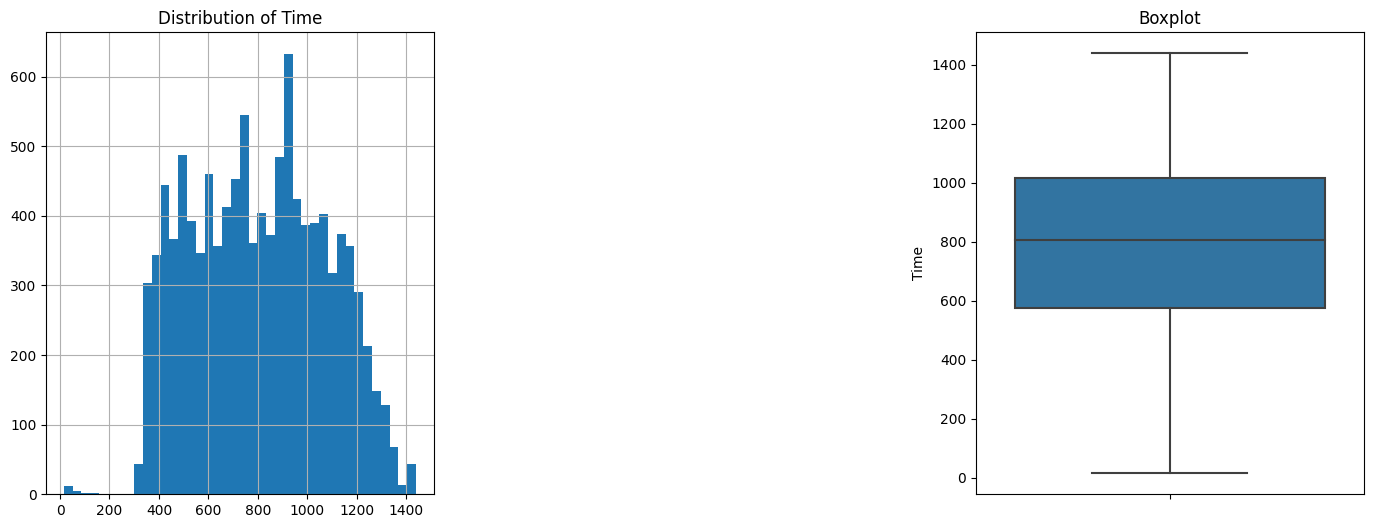

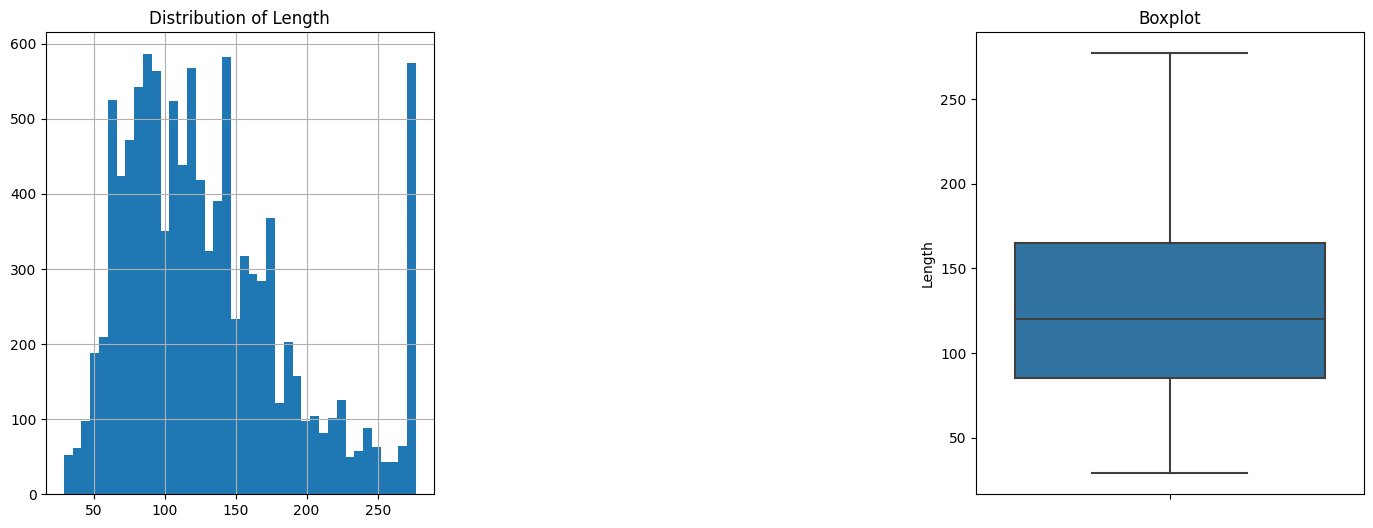

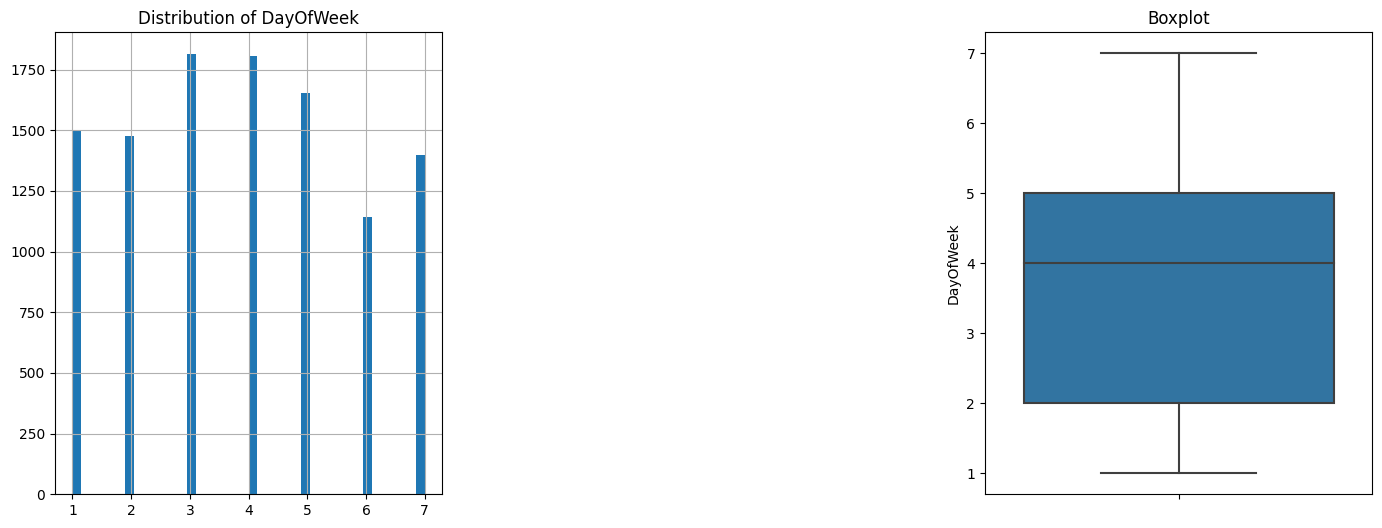

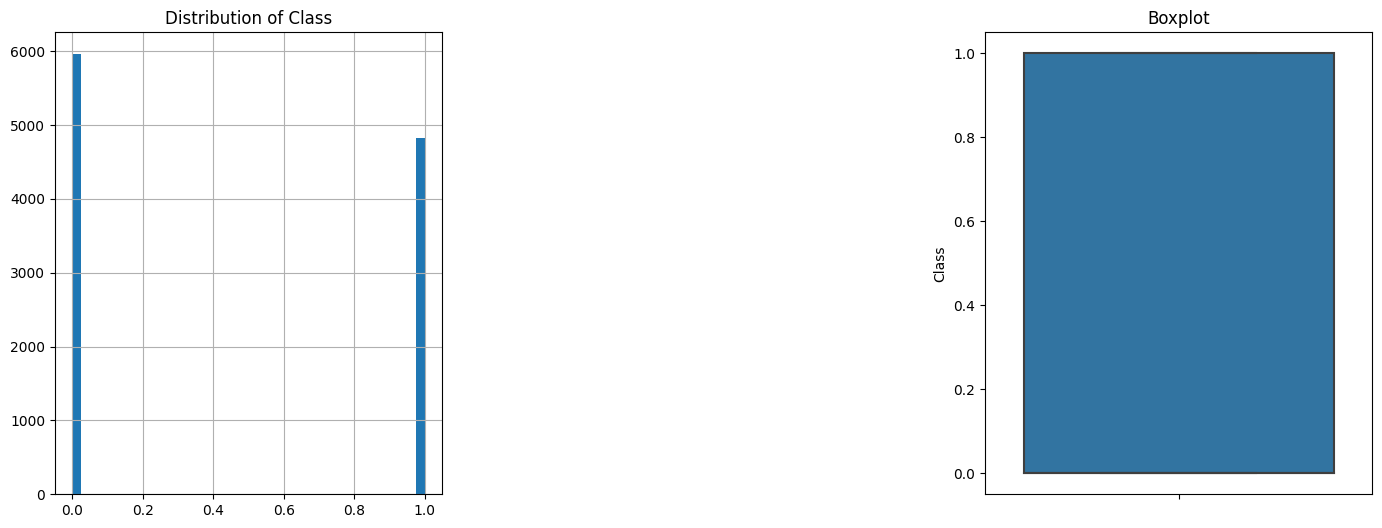

In [212]:
run_diagnostic(df)

In [213]:
# Drop FLight column because its represents unique id of flight
df = df.drop(columns=["Flight"], axis=1)

In [214]:
df.columns

Index(['Time', 'Length', 'DayOfWeek', 'Class', 'Airline', 'AirportFrom',
       'AirportTo'],
      dtype='object')

In [215]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder

num_scaler = RobustScaler()
cat_enc = LabelEncoder()

In [216]:
def transform_df_pipeline(df: pd.DataFrame):
    num_columns = df.select_dtypes(exclude="object").columns.to_list()
    cat_columns = df.select_dtypes(include="object").columns.to_list()
    df[num_columns] = num_scaler.fit_transform(df[num_columns])
    df[cat_columns] = df[cat_columns].apply(cat_enc.fit_transform)
    return df

In [217]:
transformed_df = transform_df_pipeline(df)

In [218]:
transformed_df.head()

,Time,Length,DayOfWeek,Class,Airline,AirportFrom,AirportTo
0,0.148233,0.7500,0.333333,0.0,15,125,199
1,-1.003421,-0.6750,-0.666667,0.0,12,76,170
2,-0.148233,1.7125,1.000000,0.0,5,235,64
3,-0.478905,1.4375,1.000000,1.0,15,245,162
4,-0.627138,0.1625,0.666667,1.0,4,125,160


In [220]:
describe_info_dataset(transformed_df)

Missing Value Information
 Time           0
Length         0
DayOfWeek      0
Class          0
Airline        0
AirportFrom    0
AirportTo      0
dtype: int64
               Time        Length     DayOfWeek         Class       Airline   
count  10787.000000  10787.000000  10787.000000  10787.000000  10787.000000  \
mean      -0.002389      0.144874     -0.034857      0.447576      9.627236   
std        0.614726      0.746821      0.641098      0.497267      5.337941   
min       -1.801596     -1.137500     -1.000000      0.000000      0.000000   
25%       -0.521095     -0.437500     -0.666667      0.000000      5.000000   
50%        0.000000      0.000000      0.000000      0.000000     11.000000   
75%        0.478905      0.562500      0.333333      1.000000     15.000000   
max        1.445838      1.962500      1.000000      1.000000     17.000000   

        AirportFrom     AirportTo  
count  10787.000000  10787.000000  
mean     132.577640    132.046816  
std       75.513625  

## Split Dataset

In [221]:
from sklearn.model_selection import train_test_split
X = transformed_df.drop("Class", axis=1)
y = transformed_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Model Evaluation Function

In [222]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots() #Membuat objek gambar dan sumbu menggunakan
    tick_marks = np.arange(len(class_names)) # Membuat array dengan rentang jumlah kelas yang ada

    # Menentukan tanda-tanda pada sumbu x dan y sesuai dengan array yang telah dibuat
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Membuat Heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix) #Parameter yang akan divisualisasi 
                , annot=True # Menampilkan nilai di dalam kotak heatmap
                , cmap="YlGnBu" # Skema warna pada heatmap, "YlGnBu" adalah kombinasi antara Yellow (Kuning), Green (Hijau), dan Blue (Biru).
                ,fmt='g') #Mengatur format angka menjadi notasi umum (general notation)

    # Mengatur posisi label sumbu x ke bagian atas heatmap
    ax.xaxis.set_label_position("top")

    # Mengatur tampilan grafik agar lebih rapi.
    plt.tight_layout()

    # Mengatur judul grafik, label pada sumbu y dan x
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def evaluate_classification(y_true, y_pred, target_names=["Not Delayed", "Delayed"]):
    print(classification_report(y_true # Array target yang berisi label aktual 
                                , y_pred # Array target yang berisi label prediksi
                                , target_names=target_names)) #Memberikan nama kelas yang akan ditampilkan
    plot_confusion_matrix(y_true, y_pred, target_names)

## Train Model and Evaluate Model

#### Linear Regression

In [224]:
# Memanggil fungsi LinearRegression
from sklearn.linear_model import LinearRegression

# Memanggil objek LinearRegression ke dalam variabel mlr
lr = LinearRegression()

# Melatih model
lr.fit(X_train, y_train)

LinearRegression()

In [225]:
# Memprediksi model
y_pred_lr = lr.predict(X_test)
# Nilai prediksi
print("Prediction for test set: {}".format(y_pred_lr))

Prediction for test set: [0.46746643 0.37781583 0.38280352 ... 0.52197693 0.47326264 0.26682962]


In [226]:
# Menerapkan threshold pada variabel y_pred_lr ke dalam variabel y_predict_class
y_predict_class = [1 if prob > 0.5 else 0 for prob in y_pred_lr]

              precision    recall  f1-score   support

 Not Delayed       0.59      0.78      0.67      1499
     Delayed       0.55      0.33      0.41      1198

    accuracy                           0.58      2697
   macro avg       0.57      0.56      0.54      2697
weighted avg       0.57      0.58      0.56      2697



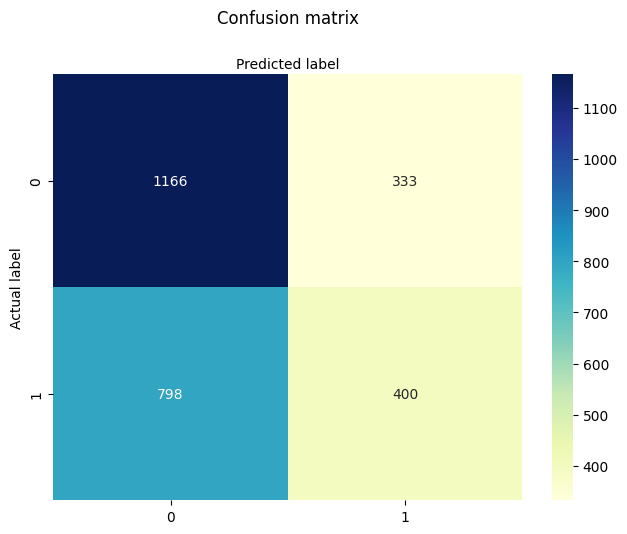

In [227]:
evaluate_classification(y_true=y_test, y_pred=y_predict_class)

### Logistic Regression

              precision    recall  f1-score   support

 Not Delayed       0.59      0.78      0.67      1499
     Delayed       0.54      0.33      0.41      1198

    accuracy                           0.58      2697
   macro avg       0.57      0.56      0.54      2697
weighted avg       0.57      0.58      0.56      2697



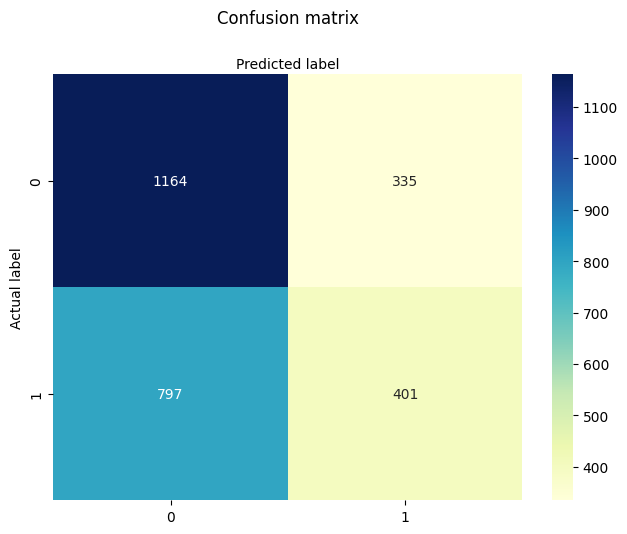

In [229]:
# Membuat Model - LogisticRegression
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(solver='lbfgs', max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

evaluate_classification(y_test, y_pred)

### KNN Classifier

In [230]:
# Membuat Model - Import Library
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

knn = KNeighborsClassifier(n_neighbors= 3) # Menentukan jumlah tetangga terdekat (nearest neighbors)

# Melatih model
knn.fit(X_train, y_train)

# Melakukan validasi silang dengan membagi data pelatihan menjadi 5 lipatan (folds)
k = KFold(n_splits = 5)

# Menghitung skor akurasi untuk setiap lipatan menggunakan metode validasi silang yang telah ditentukan
score = cross_val_score(knn
                        , X_train, y_train
                        , scoring = 'accuracy' #Parameter yang ingin digunakan
                        , cv = k).mean() # cv=k -> jumlah lipatan, .mean() -> menghitung rata-rata skor akurasi  

# Mencetak skor akurasi pada set data pelatihan dengan pembulatan ke 3 desimal
print("Accuracy on the training set:", round(score, 3))

Accuracy on the training set: 0.549


              precision    recall  f1-score   support

 Not Delayed       0.57      0.76      0.65      1499
     Delayed       0.49      0.29      0.37      1198

    accuracy                           0.55      2697
   macro avg       0.53      0.52      0.51      2697
weighted avg       0.54      0.55      0.52      2697



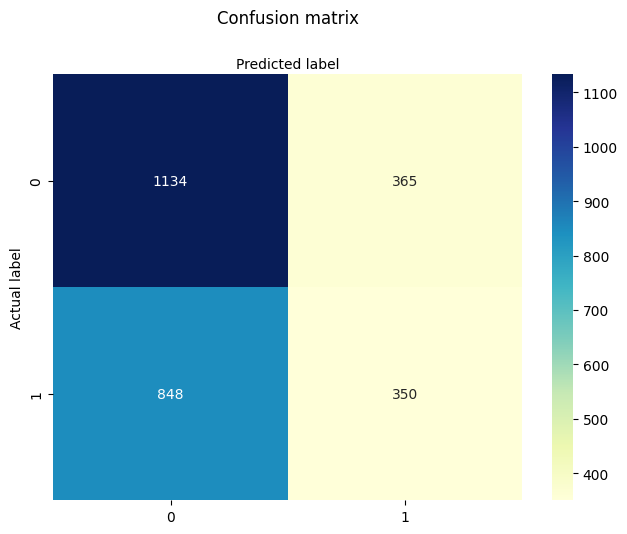

In [232]:
y_pred = knn.predict(X_test)

evaluate_classification(y_test, y_pred)

In [233]:
# Membuat list kosong dalam variabel accuracy
accuracy = []

# Membuat loop dengan rentang nilai i dari 1-14 (Exclude 15)
# Loop akan menguji setiap n dari 1-14 untuk mencari n dengan akurasi yang paling tinggi

for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    accuracy_i = accuracy_score(y_test, pred_i)
    
    # Menyimpan skor akurasi pada setiap iterasi ke dalam list "accuracy" 
    accuracy.append(accuracy_i)

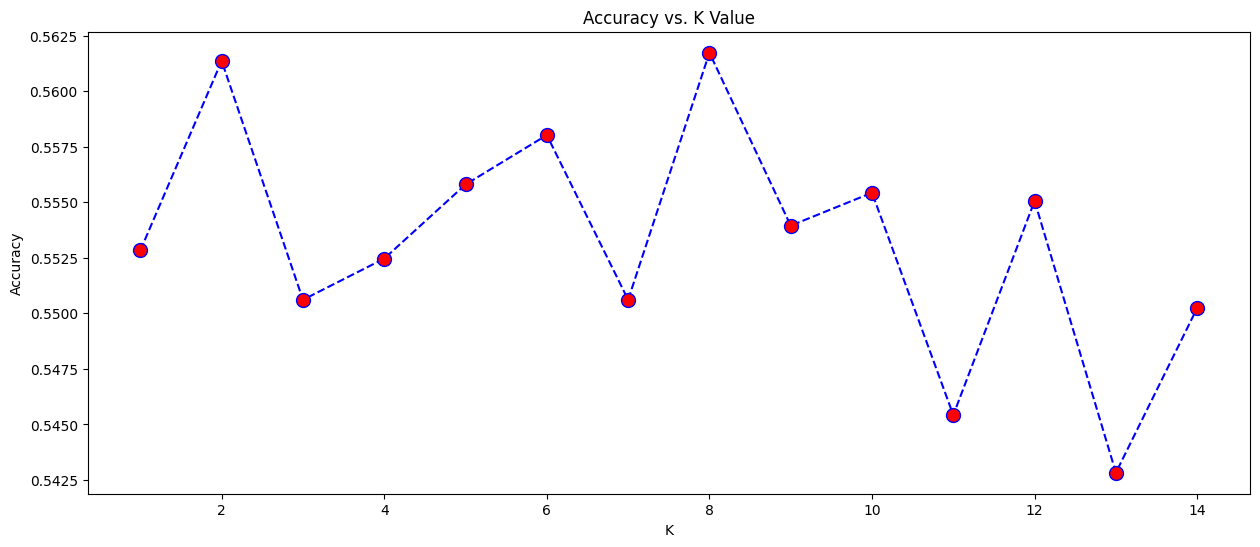

In [234]:
import matplotlib.pyplot as plt

# Melihat akurasi dari setiap iterasi pada line chart
plt.figure(figsize=(15,6))
plt.plot(range(1,15, 1), accuracy, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [235]:
# Dapat dilihat dari grafik di atas bahwa akurasi paling tinggi didapatkan dengan n = 14
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

 Not Delayed       0.57      0.83      0.68      1499
     Delayed       0.51      0.23      0.32      1198

    accuracy                           0.56      2697
   macro avg       0.54      0.53      0.50      2697
weighted avg       0.55      0.56      0.52      2697



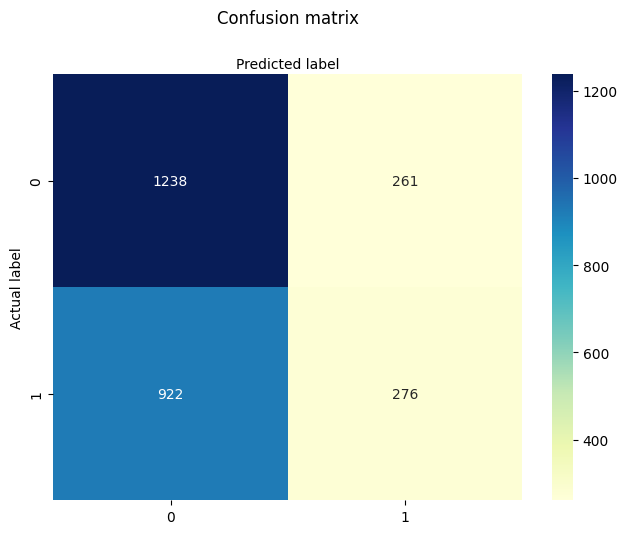

In [236]:
evaluate_classification(y_test, y_pred)

## Evaluation

| Model Name | Accuracy | Precision | Recall | F1 Score |
|------------|----------|-----------|--------|----------|
| Linear Regression | 0.58 | 0.57 | 0.56 | 0.56 |
| Logistic Regression | 0.58 | 0.57 | 0.56 | 0.56 |
| KNN | 0.55 | 0.54 | 0.55 | 0.52 |

## Simpulan

Dari hasil evaluasi ketiga model di atas didapatkan bahwa model yang memiliki performa paling baik adalah linear regression dan logistic regression dengan nilai accuracy 0.58, precision 0.57, recall 0.56, dan f1-score. Hasil ini menandakan bahwa model cukup baik dalam memprediksi apakah jadwal pesawat akan delay atau tidak.

## Future Improvement
Untuk mendapatkan performa yang lebih baik dapat dilakukan beberapa metode seperti:
- Menggunakan model lain seperti SVC, RandomForestClassifier yang lebih powerful dari ketiga model di atas.
- Melakukan feature engineering dengan cara membentuk feature baru dari dataset seperti rata-rata delay.

